# Australian Weather Forecasting - Imputing Data

## Import libraries

In [2]:
import pandas as pd
import numpy as np

## Loading Data

In [59]:
weather = pd.read_csv("weatherAUS.csv")
weather = weather.sample(3000) # remove .head(3000) to work on full data


### Filter out numeric and categorical data

In [60]:
col_list = list()
categorical = ["Date","Location","WindGustDir","WindDir9am","WindDir3pm","RainToday","RainTomorrow"]
for column in weather.columns:
    if column not in categorical:
        col_list.append(column)
numeric_data = weather[col_list]
cat_data = weather[categorical]

### Analyze Missing Data

In [61]:
def missing_data(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({'column_name': df.columns,
                                     'percent_missing': percent_missing})
    return missing_value_df
missing_data(weather)

,column_name,percent_missing
Date,Date,0.000000
Location,Location,0.000000
MinTemp,MinTemp,0.566667
MaxTemp,MaxTemp,0.266667
Rainfall,Rainfall,0.966667
Evaporation,Evaporation,42.200000
Sunshine,Sunshine,47.000000
WindGustDir,WindGustDir,7.066667
WindGustSpeed,WindGustSpeed,7.033333
WindDir9am,WindDir9am,6.633333


## Impute Numeric data and standardization
Filling missing data with the mean of our observations

In [62]:
numeric_data = numeric_data.drop(['Cloud9am','Cloud3pm','Evaporation','Sunshine'],axis=1)
numeric_data = numeric_data.apply(lambda x: x.fillna(x.mean()),axis=1)


In [63]:
numeric_data = (numeric_data - numeric_data.mean()) / (numeric_data.std())


## Impute Categorical Data
Fill missing data based on the distribution of the observed (non-missing) data

In [64]:
def impute_missing_categorical(column):
    priors = cat_data[column].value_counts()/cat_data[column].value_counts().sum()
    prior_name = priors.index
    return np.random.choice(prior_name, p=priors)

cat_data = cat_data.apply(lambda x: x.fillna(impute_missing_categorical(x.name)),axis=0)
missing_data(cat_data)

,column_name,percent_missing
Date,Date,0.0
Location,Location,0.0
WindGustDir,WindGustDir,0.0
WindDir9am,WindDir9am,0.0
WindDir3pm,WindDir3pm,0.0
RainToday,RainToday,0.0
RainTomorrow,RainTomorrow,0.0


In [65]:
missing_data(pd.concat([numeric_data,cat_data],axis=1))

,column_name,percent_missing
MinTemp,MinTemp,0.0
MaxTemp,MaxTemp,0.0
Rainfall,Rainfall,0.0
WindGustSpeed,WindGustSpeed,0.0
WindSpeed9am,WindSpeed9am,0.0
WindSpeed3pm,WindSpeed3pm,0.0
Humidity9am,Humidity9am,0.0
Humidity3pm,Humidity3pm,0.0
Pressure9am,Pressure9am,0.0
Pressure3pm,Pressure3pm,0.0


### Dataset named aussyRain

In [66]:
aussy_Rain = pd.concat([numeric_data,cat_data],axis=1)

In [79]:
import pymc3 as pm
import arviz as az
import theano
import theano.tensor as tt
import itertools
import matplotlib.pyplot as plt
import scipy.stats as scistat
import arviz as az
import warnings 


### Convert our Date column into datetime object

In [68]:
aussy_Rain['Date']=pd.to_datetime(aussy_Rain['Date'])

### Dummy encoding for other Categoricals

In [69]:
encoding = dict()
for column in aussy_Rain:
    if aussy_Rain[column].dtype == object:
        unique = aussy_Rain[column].unique()
        encoding[column] = {name: index for index, name in enumerate(unique)}
encoding

{'Location': {'Mildura': 0,
  'Williamtown': 1,
  'Uluru': 2,
  'GoldCoast': 3,
  'Nhil': 4,
  'Darwin': 5,
  'BadgerysCreek': 6,
  'CoffsHarbour': 7,
  'AliceSprings': 8,
  'Albury': 9,
  'Ballarat': 10,
  'NorahHead': 11,
  'Penrith': 12,
  'Portland': 13,
  'SydneyAirport': 14,
  'Woomera': 15,
  'Witchcliffe': 16,
  'Nuriootpa': 17,
  'Sale': 18,
  'Cobar': 19,
  'Canberra': 20,
  'SalmonGums': 21,
  'MountGinini': 22,
  'Sydney': 23,
  'Katherine': 24,
  'Hobart': 25,
  'Launceston': 26,
  'Perth': 27,
  'NorfolkIsland': 28,
  'WaggaWagga': 29,
  'MelbourneAirport': 30,
  'Townsville': 31,
  'PerthAirport': 32,
  'Watsonia': 33,
  'PearceRAAF': 34,
  'Walpole': 35,
  'Cairns': 36,
  'Albany': 37,
  'Tuggeranong': 38,
  'Dartmoor': 39,
  'Brisbane': 40,
  'Bendigo': 41,
  'MountGambier': 42,
  'Melbourne': 43,
  'Adelaide': 44,
  'Newcastle': 45,
  'Richmond': 46,
  'Wollongong': 47,
  'Moree': 48},
 'WindGustDir': {'SSW': 0,
  'SE': 1,
  'E': 2,
  'N': 3,
  'WNW': 4,
  'WSW': 5,
 

In [70]:
aussy_Rain = aussy_Rain.replace(encoding)

In [71]:
aussy_Rain.head()

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RISK_MM,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
68829,0.454063,0.861245,-0.209323,-0.066637,0.331487,-0.163372,-0.476740,-0.605293,0.350971,0.343467,0.531390,0.151394,0.180881,2010-10-12,0,0,0,0,0,0
40308,0.101611,0.158128,-0.209323,-0.208879,-0.121545,0.166634,-0.788464,-0.315970,0.327551,0.321565,0.474168,-0.033556,-0.276035,2013-12-30,1,1,1,1,0,1
142175,-1.276155,-0.199823,-0.209323,-0.095085,-0.121545,-0.021941,-1.901767,-1.151791,0.372718,0.365031,-0.887708,-0.156856,-0.276035,2017-06-07,2,2,2,2,0,1
89255,0.827875,0.707838,-0.209323,0.104053,0.709015,0.779503,-0.966593,0.584144,0.313164,0.303707,1.080718,0.023984,-0.276035,2012-11-16,3,3,3,0,0,1
72545,-0.806220,0.311535,-0.209323,-0.322672,0.331487,-0.163372,-0.432208,-0.798174,0.344948,0.337739,-0.510045,-0.041776,-0.276035,2016-11-27,4,0,4,3,0,1


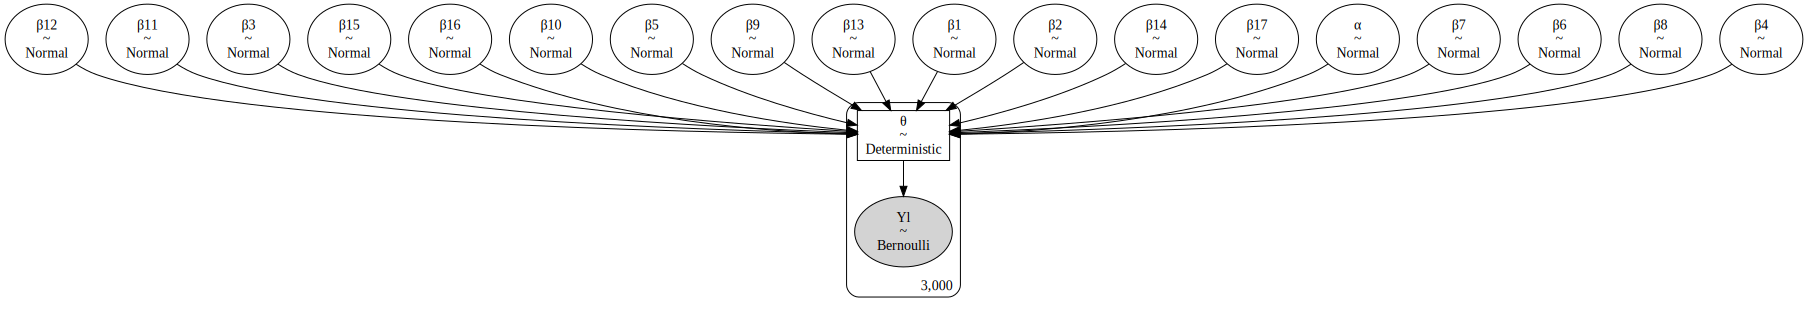

In [76]:
#### Posterior Distribution of parameters# Use pm.find_MAP() to find the maximum a-posteriori (MAP) estimate for the vector of regression coefficients .

with pm.Model() as manual_logistic_model:
    Y = aussy_Rain["RainTomorrow"]
    α = pm.Normal('α', mu=0, sd=100) 
    β1 = pm.Normal('β1', mu=0, sd=100) 
    β2 = pm.Normal('β2', mu=0, sd=100) 
    β3 = pm.Normal('β3', mu=0, sd=100) 
    β4 = pm.Normal('β4', mu=0, sd=100)
    β5 = pm.Normal('β5', mu=0, sd=100) 
    β6 = pm.Normal('β6', mu=0, sd=100)
    β7 = pm.Normal('β7', mu=0, sd=100) 
    β8 = pm.Normal('β8', mu=0, sd=100)
    β9 = pm.Normal('β9', mu=0, sd=100)
    β10 = pm.Normal('β10', mu=0, sd=100)
    β11 = pm.Normal('β11', mu=0, sd=100)
    β12 = pm.Normal('β12', mu=0, sd=100)
    β13 = pm.Normal('β13', mu=0, sd=100)
    β14 = pm.Normal('β14', mu=0, sd=100)
    β15 = pm.Normal('β15', mu=0, sd=100)
    β16 = pm.Normal('β16', mu=0, sd=100)
    β17 = pm.Normal('β17', mu=0, sd=100)

    
    μ = α + pm.math.dot(aussy_Rain["MinTemp"], β1)+pm.math.dot(aussy_Rain["MaxTemp"],β2) + pm.math.dot(aussy_Rain["Rainfall"], β3)+pm.math.dot(aussy_Rain["WindGustSpeed"],β4)  + pm.math.dot(aussy_Rain["WindSpeed9am"], β5)+pm.math.dot(aussy_Rain["WindSpeed3pm"],β6) + pm.math.dot(aussy_Rain["Humidity9am"], β7)+pm.math.dot(aussy_Rain["Humidity3pm"],β8) + pm.math.dot(aussy_Rain["Pressure9am"], β9)   + pm.math.dot(aussy_Rain["Pressure3pm"], β10)  + pm.math.dot(aussy_Rain["Pressure9am"], β11)   + pm.math.dot(aussy_Rain["RISK_MM"], β12)  + pm.math.dot(aussy_Rain["Location"], β13)  +pm.math.dot(aussy_Rain["WindGustDir"],β14)  +pm.math.dot(aussy_Rain["WindDir9am"],β15) + pm.math.dot(aussy_Rain["WindDir3pm"],β16)+ pm.math.dot(aussy_Rain["RainToday"],β17) 
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
    map_estimate = pm.find_MAP()
    #print(map_estimate)
pm.model_to_graphviz(manual_logistic_model)

In [78]:
map_estimate

{'α': array(0.78276757),
 'β1': array(-0.49876993),
 'β2': array(0.85247664),
 'β3': array(-0.43555211),
 'β4': array(-0.06481005),
 'β5': array(0.0691908),
 'β6': array(1.09604367),
 'β7': array(-0.10839657),
 'β8': array(-0.41191199),
 'β9': array(0.08457609),
 'β10': array(0.1687094),
 'β11': array(0.08457609),
 'β12': array(-5.16607272),
 'β13': array(0.00557682),
 'β14': array(5.10493433e-05),
 'β15': array(0.04673504),
 'β16': array(0.05846765),
 'β17': array(-1.22900082),
 'θ': array([0.6712237 , 0.95293189, 0.97739449, ..., 0.96819963, 0.92883561,
        0.96934392])}

In [ ]:
# Use pm.find_MAP() to find the maximum a-posteriori (MAP) estimate for the vector of regression coefficients .

with pm.Model() as manual_logistic_model:
    Y = standardized_df["chd"]
    α = pm.Normal('α', mu=0, sd=100) 
    β1 = pm.Normal('β1', mu=0, sd=100) 
    β2 = pm.Normal('β2', mu=0, sd=100) 
    β3 = pm.Normal('β3', mu=0, sd=100) 
    β4 = pm.Normal('β4', mu=0, sd=100)
    β5 = pm.Normal('β5', mu=0, sd=100) 
    β6 = pm.Normal('β6', mu=0, sd=100)
    β7 = pm.Normal('β7', mu=0, sd=100) 
    β8 = pm.Normal('β8', mu=0, sd=100)
    β9 = pm.Normal('β9', mu=0, sd=100) 
    μ = α + pm.math.dot(standardized_df["sbp"], β1)+pm.math.dot(standardized_df["tobacco"],β2) + pm.math.dot(standardized_df["ldl"], β3)+pm.math.dot(standardized_df["adiposity"],β4)  + pm.math.dot(standardized_df["typea"], β5)+pm.math.dot(standardized_df["obesity"],β6) + pm.math.dot(standardized_df["alcohol"], β7)+pm.math.dot(standardized_df["age"],β8) + pm.math.dot(standardized_df["famhist"], β9) 
    θ = pm.Deterministic('θ',  pm.invlogit(μ))
    Yl = pm.Bernoulli('Yl', p=θ, observed=Y) 
    map_estimate = pm.find_MAP()
    #print(map_estimate)
pm.model_to_graphviz(manual_logistic_model)

In [16]:
aussy_Rain['Location']

68917     0
40580     1
2303      2
7613      3
89299     4
         ..
17770    31
63882    30
92790    47
53522    15
61247    23
Name: Location, Length: 3000, dtype: int64

In [117]:
with pm.Model() as logistic_model:
        Y = aussy_Rain.RainTomorrow
        pm.glm.GLM.from_formula('Y~MinTemp+MaxTemp+Rainfall+WindGustSpeed + WindSpeed9am + WindSpeed3pm  +Humidity9am+ Humidity3pm  +Pressure9am  +Pressure3pm +Temp9am  + Temp3pm +   RISK_MM  + Location+ WindGustDir +WindDir9am +WindDir3pm +RainToday', aussy_Rain, family=pm.glm.families.Binomial())
        trace = pm.sample(1000, tune=1000, init='adapt_diag', cores=4,target_accept = 0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [RainToday, WindDir3pm, WindDir9am, WindGustDir, Location, RISK_MM, Temp3pm, Temp9am, Pressure3pm, Pressure9am, Humidity3pm, Humidity9am, WindSpeed3pm, WindSpeed9am, WindGustSpeed, Rainfall, MaxTemp, MinTemp, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1075 seconds.
There were 343 divergences after tuning. Increase `target_accept` or reparameterize.
There were 407 divergences after tuning. Increase `target_accept` or reparameterize.
There were 323 divergences after tuning. Increase `target_accept` or reparameterize.
There were 377 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


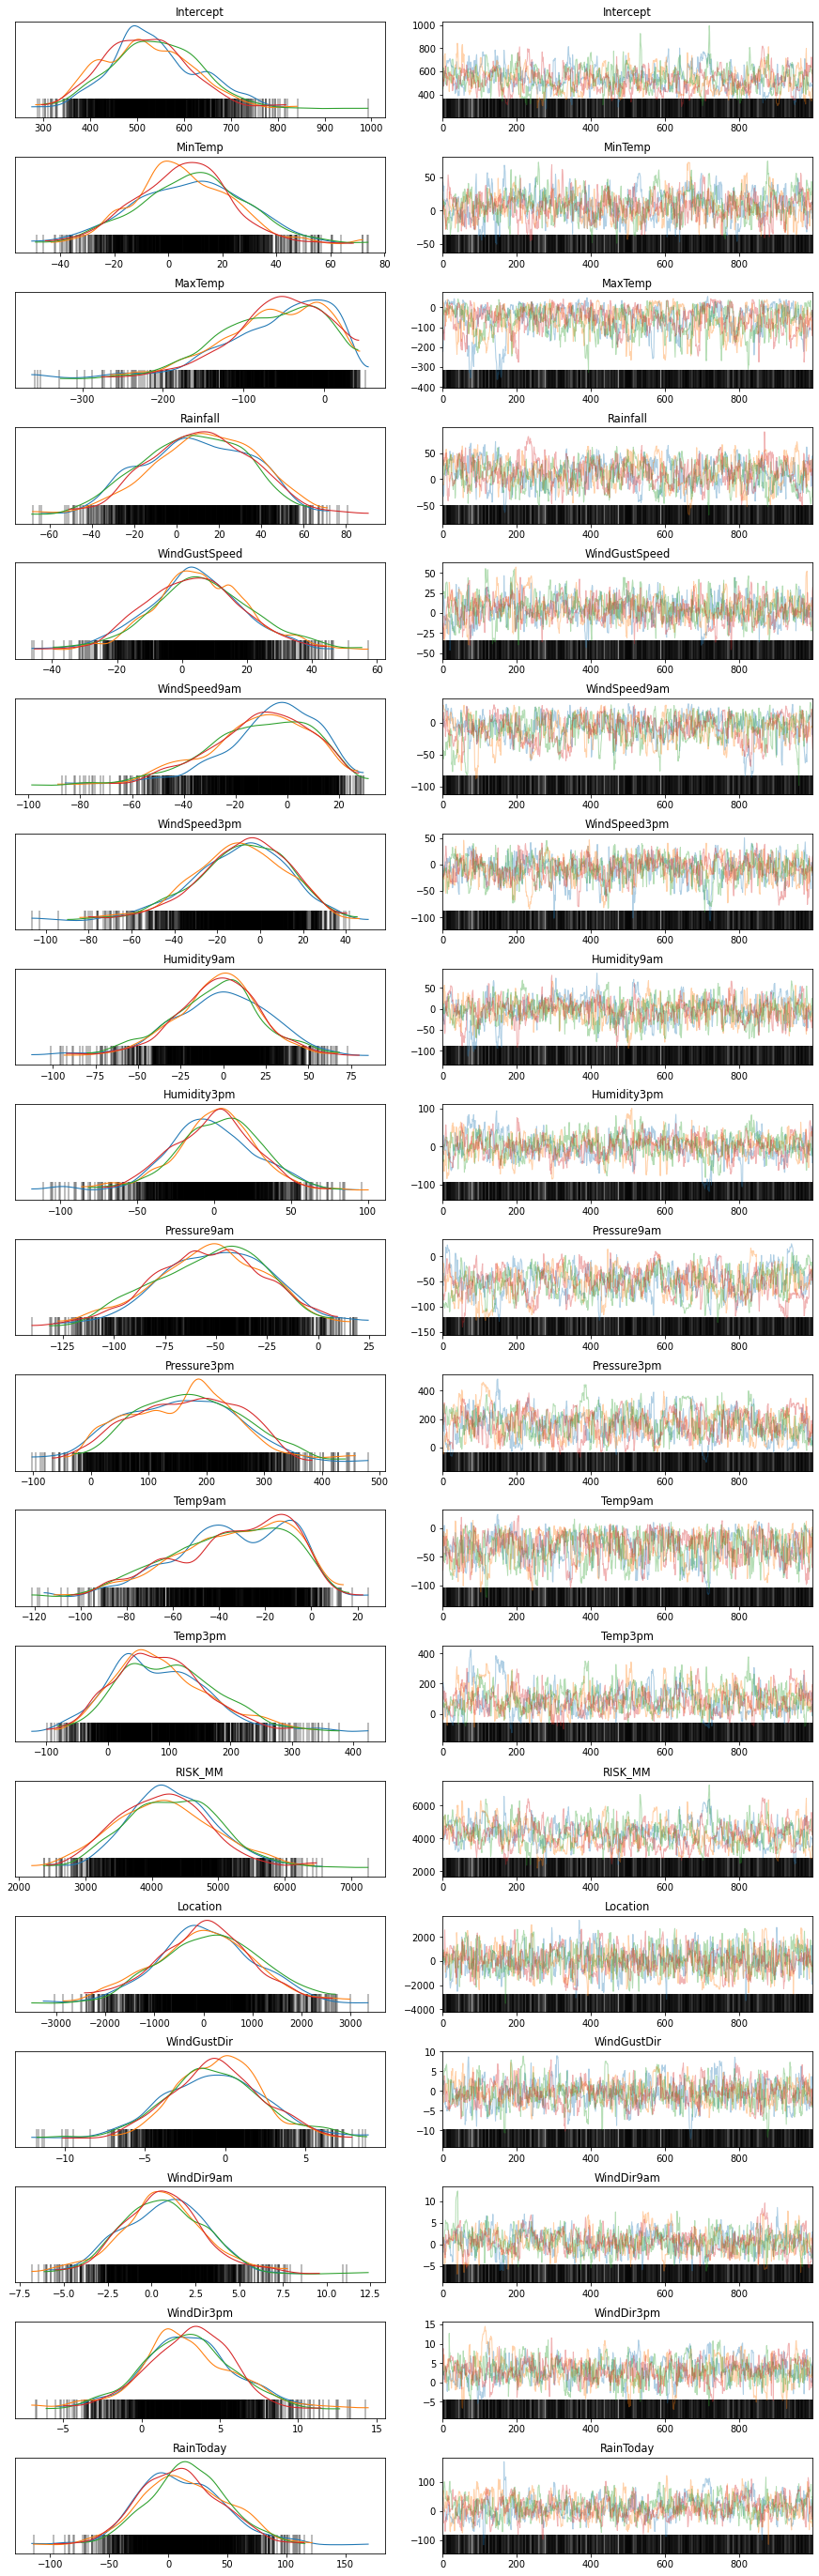

In [118]:
with logistic_model:
    az.plot_trace(trace)

### Unpooled Model

In [21]:
Local = aussy_Rain.Location.unique()
locations = len(Local)
Location_lookup = dict(zip(Local, range(len(Local))))
location_Code = aussy_Rain['Location'] = aussy_Rain.Location.replace(Location_lookup).values 
print(aussy_Rain['Location'])

68917     0
40580     1
2303      2
7613      3
89299     4
         ..
17770    31
63882    30
92790    47
53522    15
61247    23
Name: Location, Length: 3000, dtype: int64


In [31]:
Rainfall = aussy_Rain['Rainfall']
RainTomorrow =aussy_Rain['RainTomorrow']

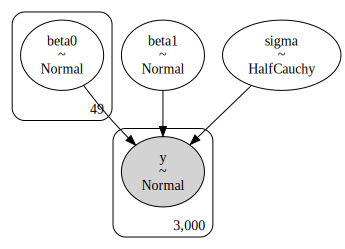

In [34]:
with pm.Model() as unpooled_model:
    beta0 = pm.Normal('beta0', 0, sd=1e5, shape=locations)
    beta1 = pm.Normal('beta1', 0, sd=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    theta = beta0[location_Code] + beta1*Rainfall
    y = pm.Normal('y', theta, sd=sigma, observed=RainTomorrow)
pm.model_to_graphviz(unpooled_model)

In [35]:
with unpooled_model:
    unpooled_trace = pm.sample(1000, cores = 4, tune=1000)
    unpooled_idata = az.from_pymc3(unpooled_trace)
az.summary(unpooled_idata, round_to=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.14,0.05,0.05,0.23,0.0,0.0,9503.37,7088.05,9518.44,2739.08,1.0
beta0[1],0.19,0.05,0.08,0.28,0.0,0.0,10465.27,7326.91,10416.92,2913.64,1.0
beta0[2],0.13,0.05,0.03,0.23,0.0,0.0,10832.17,7558.96,10916.79,2659.06,1.0
beta0[3],0.13,0.05,0.05,0.22,0.0,0.0,8183.34,6720.54,8046.66,2736.88,1.0
beta0[4],0.26,0.05,0.16,0.36,0.0,0.0,9431.30,8119.55,9420.98,2871.27,1.0
beta0[5],0.16,0.05,0.07,0.25,0.0,0.0,11353.51,9215.23,11294.95,2830.29,1.0
beta0[6],0.17,0.05,0.09,0.26,0.0,0.0,10319.01,8856.79,10318.27,2945.14,1.0
beta0[7],0.07,0.07,-0.07,0.19,0.0,0.0,10162.21,3732.46,10121.89,2901.54,1.0
beta0[8],0.09,0.06,-0.01,0.20,0.0,0.0,11128.37,5369.71,11098.85,2867.87,1.0
beta0[9],0.24,0.05,0.15,0.34,0.0,0.0,10323.23,9753.16,10330.01,2938.38,1.0


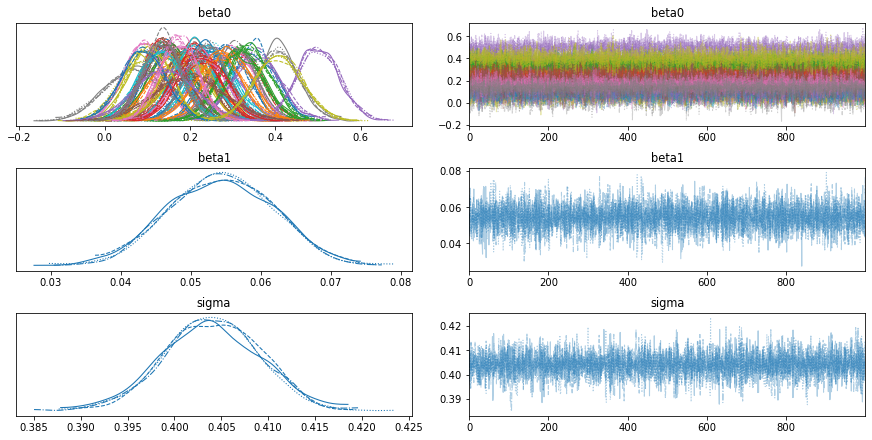

In [49]:
with unpooled_model:
    pm.traceplot(unpooled_trace)

In [50]:
estimate_unpool = pd.Series(unpooled_trace['beta0'].mean(axis=0), index=Location_lookup)
se_unpool = pd.Series(unpooled_trace['beta0'].std(axis=0), index=Location_lookup)

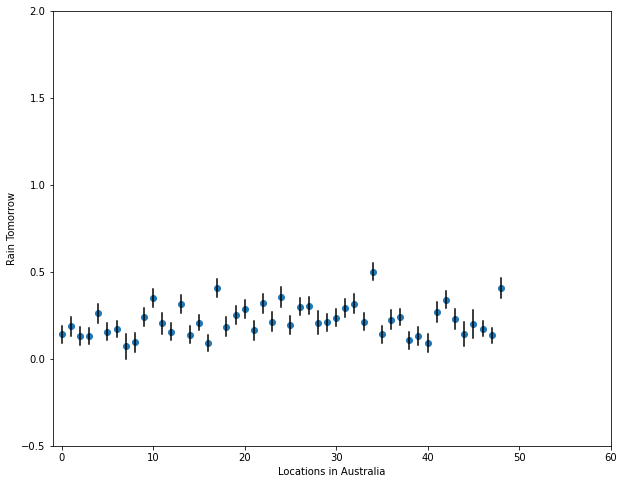

In [52]:
plt.figure(figsize = (10,8))
plt.scatter(range(len(estimate_unpool)), estimate_unpool)
for i, m, se in zip(range(len(estimate_unpool)), estimate_unpool, se_unpool):
    plt.plot([i,i], [m-se, m+se], 'black')
plt.xlim(-1,60); plt.ylim(-0.5,2)
plt.ylabel('Rain Tomorrow');plt.xlabel('Locations in Australia');

### Hierachical Model 

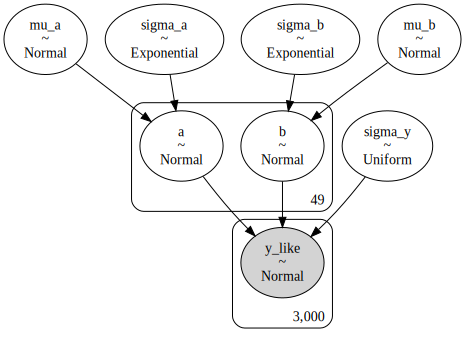

In [37]:
with pm.Model() as intercept_model:
    #Priors
    mu_a = pm.Normal('mu_a', mu=0., sd=100)
    sigma_a = pm.Exponential("sigma_a", 0.5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100)
    sigma_b = pm.Exponential("sigma_b", .5)

    #Intercept, Random
    a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=locations)
    # Random slopes
    b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=locations)
    #Error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    #E(X)
    y_hat = a[location_Code] + b[location_Code] * Rainfall
    #Likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sd=sigma_y, observed=RainTomorrow)
    
pm.model_to_graphviz(intercept_model)

In [38]:
with intercept_model:
    intercept_model = pm.sample(3500, step = pm.NUTS(target_accept = 0.999), cores = 4, tune=1000)
    intercept_model_idata = az.from_pymc3(intercept_model)
az.summary(intercept_model_idata, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_y, b, a, sigma_b, mu_b, sigma_a, mu_a]


Sampling 4 chains for 1_000 tune and 3_500 draw iterations (4_000 + 14_000 draws total) took 210 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,0.24,0.01,0.21,0.26,0.0,0.0,8167.52,8167.52,8160.46,9163.02,1.0
mu_b,0.22,0.04,0.15,0.30,0.0,0.0,5482.92,5482.92,5510.40,8384.44,1.0
a[0],0.21,0.05,0.12,0.29,0.0,0.0,12118.71,11829.01,12118.50,10864.03,1.0
a[1],0.20,0.04,0.12,0.28,0.0,0.0,15517.66,15177.81,15526.14,9231.22,1.0
a[2],0.17,0.04,0.09,0.26,0.0,0.0,15298.69,14880.19,15317.53,10115.91,1.0
...,...,...,...,...,...,...,...,...,...,...,...
b[47],0.15,0.04,0.07,0.23,0.0,0.0,16191.54,15205.58,16194.19,10498.01,1.0
b[48],0.08,0.10,-0.10,0.27,0.0,0.0,16235.83,10965.56,16230.87,11053.56,1.0
sigma_a,0.07,0.01,0.05,0.10,0.0,0.0,5964.12,5964.12,5825.85,7757.19,1.0
sigma_b,0.22,0.04,0.15,0.29,0.0,0.0,3569.46,3569.46,3615.01,6777.25,1.0


/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu_a'}>,
        <AxesSubplot:title={'center':'mu_a'}>],
       [<AxesSubplot:title={'center':'mu_b'}>,
        <AxesSubplot:title={'center':'mu_b'}>],
       [<AxesSubplot:title={'center':'a'}>,
        <AxesSubplot:title={'center':'a'}>],
       [<AxesSubplot:title={'center':'b'}>,
        <AxesSubplot:title={'center':'b'}>],
       [<AxesSubplot:title={'center':'sigma_a'}>,
        <AxesSubplot:title={'center':'sigma_a'}>],
       [<AxesSubplot:title={'center':'sigma_b'}>,
        <AxesSubplot:title={'center':'sigma_b'}>],
       [<AxesSubplot:title={'center':'sigma_y'}>,
        <AxesSubplot:title={'center':'sigma_y'}>]], dtype=object)

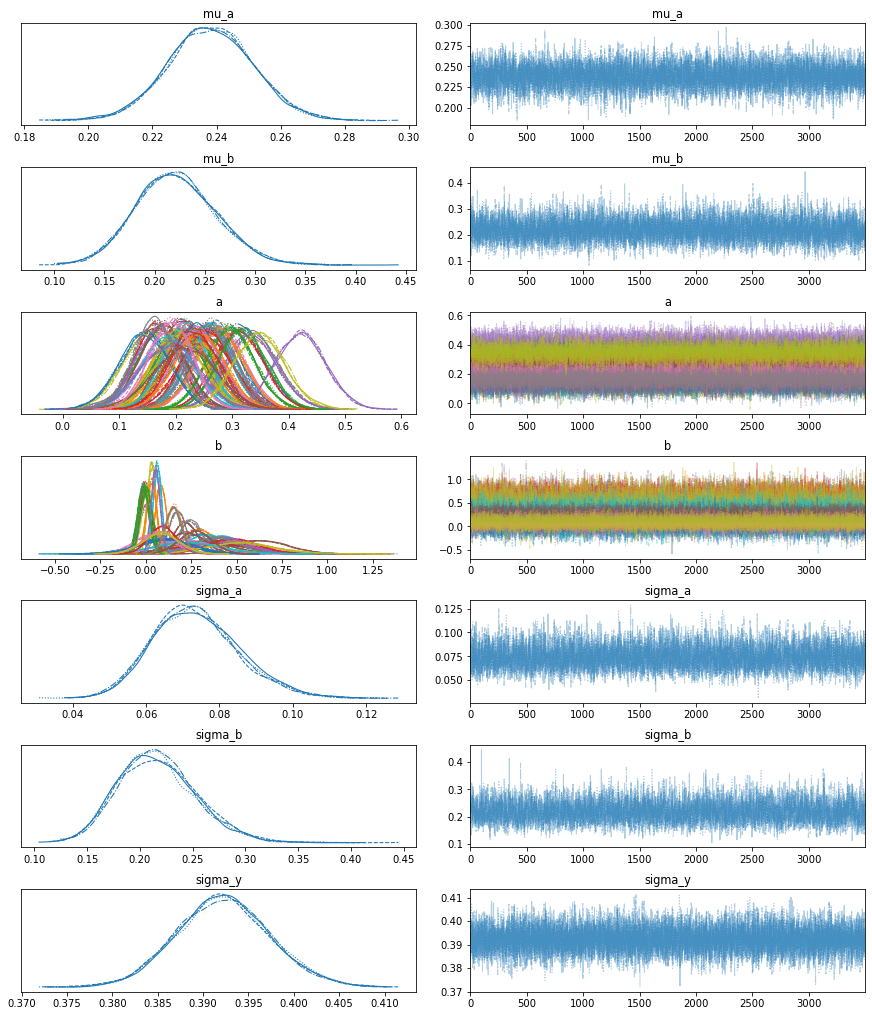

In [40]:
pm.traceplot(intercept_model)